# Volume 3: Intro to Deep Learning
    Benj McMullin
    Math 405
    4/2/2024

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

import urllib.request as urlrq
import certifi
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#assert torch.cuda.is_available()

# Problem 1
Create the device variable.
Download the CIFAR10 training and test datasets.
Transform them into tensors and normalize them.

In [4]:
# Set the device to GPU if available, otherwise to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define data transformation pipeline: convert images to PyTorch tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # Normalize tensor values
])

# Download the CIFAR10 training dataset and apply the defined transformation
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transform)

# Download the CIFAR10 test dataset and apply the same transformation as for the training data
test_data = datasets.CIFAR10('./test_data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:11<00:00, 14510782.11it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


100%|██████████| 170498071/170498071 [00:12<00:00, 13747158.83it/s]


Extracting ./test_data\cifar-10-python.tar.gz to ./test_data


# Problem 2
Split the data into train, validation, and test sets, and create DataLoaders for each one. Use a batch size of 32 for the training set and 1 for the validation and test sets.

In [5]:
# Get data for training and validation
# We take the first 40,000 samples for training and the remaining 10,000 samples for validation
actual_train_data = [train_data[i] for i in range(40_000)]  # Training data
valid_data = [train_data[i] for i in range(40_000, 50_000)]  # Validation data

# Create DataLoaders
# DataLoader loads data into batches to feed into the model during training
train_loader = DataLoader(actual_train_data, batch_size=32, shuffle=True)  # Training DataLoader
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=False)  # Validation DataLoader
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)  # Test DataLoader

# Problem 3

Create a class for a convolutional neural network that accepts images as $3\times 32 \times 32$ tensors and returns a 1D tensor of length 10, representing its predicted probabilities of each class.

The model should have at least three convolution layers, each followed by an activation function, a max pooling layer, and at least two linear layers.
Be sure that your final activation function is the softmax function.
Choose the size of the layers so that your model has at least 50,000 parameters, and record this calculation in the Jupyter notebook.

In [6]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Set up Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=8, kernel_size=2, padding=1)  # Second convolutional layer
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=5, kernel_size=4, padding=1)  # Third convolutional layer
        
        # Max Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # Flatten Layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.linear1 = nn.Linear(in_features=1280, out_features=100)  # First fully connected layer
        self.linear2 = nn.Linear(in_features=100, out_features=10)  # Second fully connected layer
        
        # Activation functions
        self.relu = nn.ReLU()  # ReLU activation function
        self.softmax = nn.Softmax(dim=1)  # Softmax activation function
        
    def forward(self, x):
        # Forward pass
        
        # Convolutional layers
        x_layer1 = self.relu(self.conv1(x))  # Apply first convolutional layer with ReLU activation
        x_layer2 = self.relu(self.conv2(x_layer1))  # Apply second convolutional layer with ReLU activation
        x_layer3 = self.relu(self.conv3(x_layer2))  # Apply third convolutional layer with ReLU activation
        
        # Max pooling layer
        x_layer4 = self.pool(x_layer3)  # Apply max pooling
        
        # Flatten layer
        x_flat = self.flatten(x_layer4)  # Flatten the output
        
        # Fully connected layers
        x_layer6 = self.relu(self.linear1(x_flat))  # Apply first fully connected layer with ReLU activation
        output = self.softmax(self.linear2(x_layer6))  # Apply second fully connected layer with softmax activation
        
        return output

In [8]:
# Instantiate MyCNN model
model = MyCNN()

# Get a sample input from the training data and add a batch dimension
x = train_data[0][0].unsqueeze(0)

# Forward pass through the model
output = model.forward(x)

# Print the output
print(output)

# Function to count the number of trainable parameters in the model
def count_parameters(model):
    # Count the number of parameters that require gradients
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the total number of trainable parameters in the model
print("Total number of trainable parameters in the model:", count_parameters(model))

tensor([[0.0957, 0.0983, 0.0933, 0.1068, 0.0998, 0.1087, 0.0970, 0.1031, 0.0979,
         0.0994]], grad_fn=<SoftmaxBackward0>)
Total number of trainable parameters in the model: 130123


# Problem 4
Send your model to the device and instantiate the objective and optimizer.
Train your model with a TQDM display, and calculate the Validation Accuracy after each epoch. 
Begin by initializing your TQDM loop, then for each epoch, do the following:

1. Set your model to training mode (model.train())
2. Instantiate an empty loss_list
3. For each batch in train_loader:
    - Send x and y_truth to device
    - Zero out the gradients 
    - Use model to predict labels of x
    - Calculate loss between predicted labels and y_truth
    - Append loss (loss.item()) to loss_list
    - Update TQDM loop 
    - Backpropagate to compute gradients 
    - Optimize and update the weights
4. Save the loss mean as the mean of the losses in loss_list
5. Set your model to evaluation mode (model.eval())
6. Calculate and save validation accuracy
Finish the training by closing your TQDM loop.

Train for 10 epochs, saving the mean loss and validation accuracy for each epoch.
Plot the mean losses and validation accuracies.

Finally, print the final test score.

In [9]:
def fit(model, train_loader, valid_loader, num_epochs=10):
    # Send the model to the appropriate device (GPU or CPU)
    model.to(device)
    
    # Instantiate loss function and optimizer
    objective = nn.CrossEntropyLoss()  # Cross-entropy loss function for classification tasks
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer with a learning rate of 0.0001

    # Set up progress bar to monitor training progress
    loop = tqdm(total=len(train_loader), position=0)
    
    # Lists to store mean losses and validation accuracies for each epoch
    mean_losses, validation_accuracies = [], []
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        loss_list = []  # List to store losses for each batch
        
        # Iterate through batches in the training data loader
        for x, y_truth in train_loader:
            x, y_truth = x.to(device), y_truth.to(device)  # Move input data to the appropriate device
            optimizer.zero_grad()  # Zero the gradients
            y_hat = model(x)  # Forward pass
            loss = objective(y_hat, y_truth)  # Calculate the loss
            loss_list.append(loss.item())  # Append the loss value to the list
            loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch, loss.item()))  # Update progress bar
            loop.update()  # Update progress bar
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimizer step
            
        # Compute the mean loss for the epoch
        loss_mean = np.mean(loss_list)
        mean_losses.append(loss_mean)
        
        # Validation Loop
        model.eval()  # Set the model to evaluation mode
        validation_score = 0  # Initialize validation score
        for x, y_truth in valid_loader:
            x, y_truth = x.to(device), y_truth.to(device)  # Move input data to the appropriate device
            y_hat = model(x)  # Forward pass
            if y_truth == y_hat.argmax(1):  # Check if the predicted label matches the true label
                validation_score += 1  # Increment validation score if prediction is correct
        validation_accuracy = validation_score / len(valid_loader)  # Compute validation accuracy
        validation_accuracies.append(validation_accuracy)  # Append validation accuracy to list

    loop.close()  # Close the progress bar
    
    return model, mean_losses, validation_accuracies  # Return trained model and evaluation metrics

In [10]:
# Train the model using the fit function and obtain the trained model, mean losses, and validation accuracies
model, means, validation_accuracies = fit(model, train_loader, valid_loader)

epoch:9, loss:2.0980: : 12500it [10:09, 20.50it/s]                       


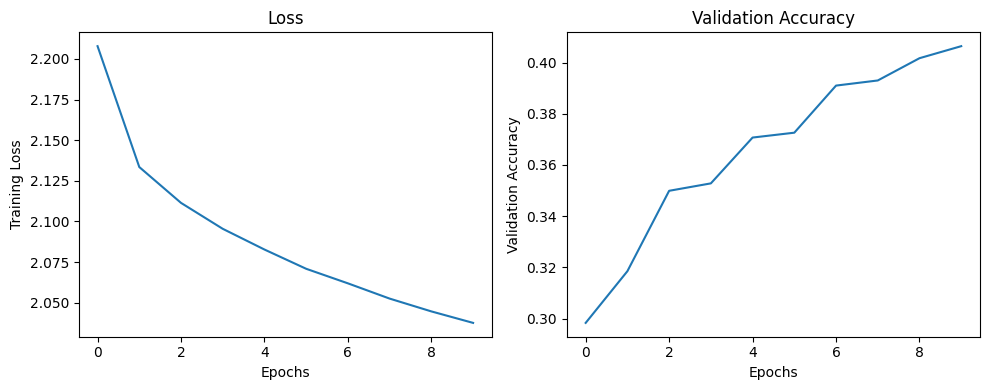

In [11]:
# Plot it
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(means)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Loss")

plt.subplot(122)
plt.plot(validation_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")

plt.tight_layout()
plt.show()

# Problem 5

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [12]:
# FGSM attack code
def fgsm_attack(model, optimizer, objective, x, y, eps):
    """
    Performs the FGSM attack on the given model and data point x with label y.
    Returns the perturbed data point.
    """
    # Calculate the gradient
    x.requires_grad = True
    x.retain_grad()
    optimizer.zero_grad()
    output = model(x)
    loss = objective(output, y)
    loss.backward()
    data_grad = x.grad.data
    # Perturb the images
    x_perturbed = x + eps * data_grad.sign()
    return x_perturbed

In [13]:
# List to store test scores for each epsilon value
test_scores = []

# Iterate through different epsilon values
for i, eps in enumerate([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    test_score = 0
    
    # Iterate through the test set
    for x, y_truth in test_loader:
        x, y_truth = x.to(device), y_truth.to(device)  # Move input data to the appropriate device
        
        # Perturb the input using FGSM attack
        x_perturbed = fgsm_attack(model, optim.Adam(model.parameters(), lr=1e-4), nn.CrossEntropyLoss(), x, y_truth, eps)
        
        # Make predictions on the perturbed input
        y_hat = model(x_perturbed)
        
        # Check if the prediction matches the true label
        if y_truth == y_hat.argmax(1):
            test_score += 1  # Increment test score if prediction is correct
            
    # Compute and append the accuracy for the current epsilon value
    test_scores.append(test_score / 10000)  # Divide test score by total number of samples (10000) to get accuracy

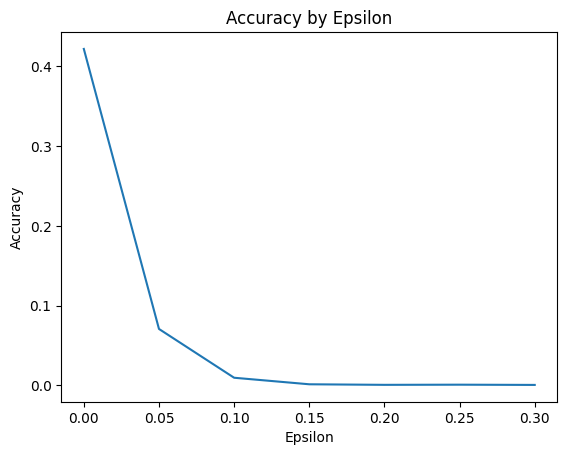

In [14]:
# Plot
epsilons = [0,.05,.1,.15,.2,.25,.3]
plt.plot(epsilons, test_scores)
plt.title("Accuracy by Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


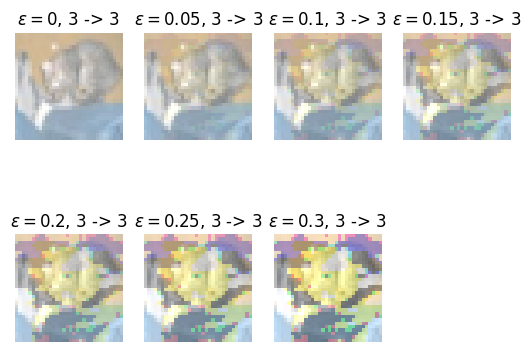

In [15]:
# Set the model to evaluation mode
model.eval()

# Iterate through different epsilon values
for i, eps in enumerate([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    # Get the first image from the test loader
    for x, y_truth in test_loader:
        x, y_truth = x.to(device), y_truth.to(device)  # Move input data to the appropriate device
        break  # Break the loop after obtaining the first image
    
    # Perturb the input using FGSM attack
    x_perturbed = fgsm_attack(model, optim.Adam(model.parameters(), lr=1e-4), nn.CrossEntropyLoss(), x, y_truth, eps)
    
    # Detach the tensor, move it to CPU, and convert it to a numpy array
    ex = x_perturbed.squeeze().detach().cpu().numpy()
    
    # Rescale the image from [-1, 1] to [0, 1]
    img = ex / 2 + 0.5
    
    # Plot the perturbed image
    plt.subplot(2, 4, i + 1)  # Create subplot
    plt.title(f"$\epsilon={eps}$, {str(y_truth)[8]} -> {str(model(x).argmax(1))[8]}")  # Set title
    plt.axis('off')  # Turn off axis
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Display the image with appropriate dimensions
